# ICDSS Advanced Team Submission - Fashion MNIST Classification

#### Author: Ricardo Mokhtari

# Goal

To build a model that is able to accuractly classify greyscale images of clothing into 1 of 10 clothing categories.

# Abstract

My work begins with a brief exploration and visualisation of the Fashion MNIST dataset by creating a UMAP embedding of the training set images. This allows me to qualitatively identify which classes are most closely related and gives an idea of which will be the most difficult for a model to classify. I employed 2 models for this task: a Convolutional Neural Network (CNN) and a Capsule Network. I found that the CNN marginally outperformed the Capsule Network, achieving an accuracy of 91.66% on the test set. However, longer training of the Capsule Network may produce improved results. I conclude by outlining improvements that can be made to the CNN. I suggest a hyperparameter optimisation via grid search and data augmentation using a Generative Adversarial Network (GAN).

# Contents

1. Data Visualisation
2. Convolutional Neural Network (CNN)
3. Capsule Network
4. Improvements
___

## 1. Data Visualisation

Since the Fashion MNIST dataset has very high dimensionality (60000x784), the best way to visualise this data will be through a dimensionality reduction technique. For this I will use the Unifold Manifold Approximation Projection (UMAP) embedding, which has several advantages over other dimensionality reduction techniques such as t-SNE and PCA.
UMAP will allow us to visualise the relationship between each class in a geometric space.

#### UMAP vs. PCA

PCA is a linear dimensionality reduction technique, which is not suitable in our case since the relationship between Fashion MNIST image classes is highly non linear.

#### UMAP vs. t-SNE

UMAP is several times faster than t-SNE and also is more robust to high dimensional data, which is exactly what we are dealing with here.

We will apply the UMAP embedding to the training set.

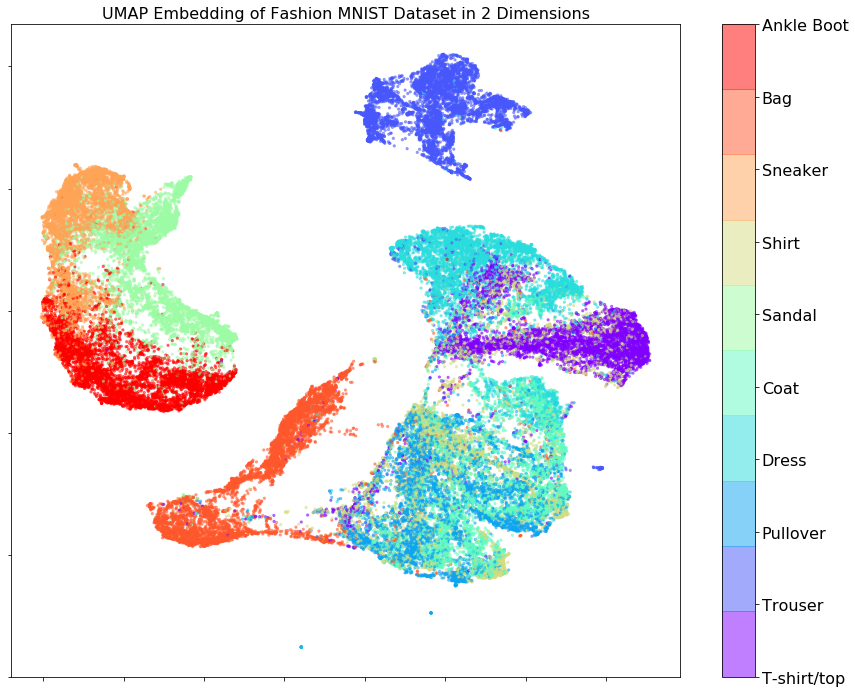

In [10]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

from reader import get_images
(x_train, y_train), (x_test, y_test) = get_images()

# create UMAP embedding
embedding = umap.UMAP(n_neighbors=5, min_dist=0.1).fit_transform(x_train[:, :])

# create figure
fig, ax = plt.subplots(figsize=(15,12))

# define a colourmap with 10 colours
cmap = cm.get_cmap('rainbow', 10)

# scatter plot of embeddings
cax = ax.scatter(embedding[:, 0], embedding[:, 1], 
            c=y_train, 
            alpha=0.5,
            cmap=cmap,
            s=5)

ax.set_yticklabels([])
ax.set_xticklabels([])

# define a custom colourbar
cbar = fig.colorbar(cax, ticks=[0,1,2,3,4,5,6,7,8,9])
cbar.ax.set_yticklabels(['T-shirt/top', 'Trouser', 'Pullover','Dress','Coat',
                         'Sandal','Shirt','Sneaker','Bag','Ankle Boot'],fontsize=16)

plt.title("UMAP Embedding of Fashion MNIST Dataset in 2 Dimensions",fontsize=16)
plt.show()

We can see based on the distances between classes that the UMAP has worked correctly - similar objects of clothing (shirt, pullover, coat) are overlapping and unique items do not (bag and trousuer).

Since the Trouser and Bag classes are well separated, this is a good indication that our model will be able to distinctly classify these two classes with good accuracy. However, other classes overlap (Ankle Boot, Sandal and Sneaker overlap as do Coat, Pullover, Dress and t-shirt/top), which suggests that these classes will be more difficult for our model to classify and hence be the source of the largest error.
___

## 2. Convolutional Neural Network (CNN)

The task here is classification. Since the dataset is extremely large, high dimensional (each image contains 784 pixels/features) and the relationship between these pixels and the target classes is extremely non linear, we should use a CNN classsifier to perform this task. I am most comfortable with PyTorch, so I will use this framework.

First, the data needs to be imported in a PyTorch-compatible way. For this, I use `torchvision.dataset.FashionMNIST` to download the data and apply a normalisation transform. This is slightly more straightforward than having to manipulate the numpy dataset provided in the challenge description.

The transform I apply is simple - 1) Convert each image to a `torch.Tensor` 2) Normalise the image values between -1 and 1.

I also define a batch size of 60 (Fashion MNIST is very large so a large batch size will stabilise and speed up training).

In [14]:
# imports
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets

# define the transform
compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])

# define batch size
batch = 60

# create iterable training and test sets
trainset = datasets.FashionMNIST(root="./data", train=True, transform=compose, download=True)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch, shuffle=True,
                                          num_workers=2)

testset = datasets.FashionMNIST(root="./data", train=False, transform=compose, download=True)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch, shuffle=False,
                                          num_workers=2)

# define the classes in the data
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Now I define the network. This is a deep neural network with 5 total layers (3 hidden layers). We have the input layer, 1 convolutional layer, 2 fully connected layers and the output layer. I use a deep architecture because when dealing with images we want at least a layer(s) performing feature extraction via convolution, followed by a standard fully connected architecture. 

Since the input images are quite small (28x28) and greyscale, using many convolutional layers will result in very small feature maps that are not information rich. For this reason, I will use one convolution layer with a high number of output feature maps (64).

Each layer is described with a comment. In PyTorch we first define a CNN class with associated methods and define a 'forward' function for propagating the network. We then create and instance of the CNN and append a loss function and optimisation algorithm.

Below is a visualisation of the network and the shape of the data as it moves through (generated with Keras).

<img src="neural-net.png" />

In [15]:
# define the network
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # first convolutional layer - output is 16 channels
        # FMNIST is greyscale so input is 1 channel
        # apply padding=2 for better performance
        self.conv1 = nn.Conv2d(1,64,3,padding=2)
        
        # max pooling operation (2x2 window, stride = 2)
        self.pool = nn.MaxPool2d(2,2)
        
        # fully connected layer 1
        # input is 64 15x15 feature maps - output is 120 dim vector
        self.fc1 = nn.Linear(15*15*64,120)
        
        # fully connected layer 2
        # output is 84 dim vector
        self.fc2 = nn.Linear(120, 84)
        
        # output layer - output has 10 neurons because
        # we are predicting 10 classes
        self.fc3 = nn.Linear(84, 10) 
    
    # forward propagation through network
    def forward(self, x):
        # convolution + relu + max pool
        x = self.pool(F.relu(self.conv1(x)))
        
        # flatten data for FC layers
        x = x.view(-1,15*15*64)
        
        # fc layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # output layer
        x = self.fc3(x)
        
        # return output
        return x

# instantiate CNN
cnn = CNN()

# define a loss function
loss_criterion = nn.CrossEntropyLoss()

# optimisation algorithm is stochastic gradient descent
# usual parameters are learning rate of 0.001 and momentum of 0.9
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In PyTorch we define a custom training loop (there is no fit method). In this loop we forward propagate, calculate loss based on the loss function defined above and use this loss to update the weights in the direction of that minimises loss.

I will train for 50 epochs, the loss will be printed at each epoch.

In [16]:
n_epochs = 50

for epoch in range(n_epochs):
    
    running_loss = 0.0
    
    for counter, data in enumerate(trainloader, 0):
        
        # unpack the training data into labels and images (x & y pair)
        images, labels = data
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward propagation
        output = cnn(images)
        # calculate loss
        loss = loss_criterion(output, labels)
        # backpropagate loss
        loss.backward()
        # update weights
        optimizer.step()
        # record loss
        running_loss += loss.item()
        
        # print training statistics
        running_loss += loss.item()
        if counter % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, counter + 1, running_loss / 1000))
            running_loss = 0.0

print("finished training")

[1,  1000] loss: 1.610
[2,  1000] loss: 0.909
[3,  1000] loss: 0.793
[4,  1000] loss: 0.722
[5,  1000] loss: 0.681
[6,  1000] loss: 0.640
[7,  1000] loss: 0.607
[8,  1000] loss: 0.586
[9,  1000] loss: 0.563
[10,  1000] loss: 0.539
[11,  1000] loss: 0.522
[12,  1000] loss: 0.504
[13,  1000] loss: 0.487
[14,  1000] loss: 0.471
[15,  1000] loss: 0.459
[16,  1000] loss: 0.448
[17,  1000] loss: 0.432
[18,  1000] loss: 0.422
[19,  1000] loss: 0.408
[20,  1000] loss: 0.394
[21,  1000] loss: 0.382
[22,  1000] loss: 0.376
[23,  1000] loss: 0.362
[24,  1000] loss: 0.353
[25,  1000] loss: 0.346
[26,  1000] loss: 0.333
[27,  1000] loss: 0.322
[28,  1000] loss: 0.314
[29,  1000] loss: 0.307
[30,  1000] loss: 0.294
[31,  1000] loss: 0.289
[32,  1000] loss: 0.280
[33,  1000] loss: 0.271
[34,  1000] loss: 0.262
[35,  1000] loss: 0.252
[36,  1000] loss: 0.248
[37,  1000] loss: 0.237
[38,  1000] loss: 0.229
[39,  1000] loss: 0.222
[40,  1000] loss: 0.214
[41,  1000] loss: 0.204
[42,  1000] loss: 0.200
[

We can now evaluate the performance of the CNN model. I will calculate the accuracy across the whole test set, defined as the number of correct predictions divided by the number of values in the test set. This metric is easily interpretable, easily comparable with literature and suitable since the test set is uniformly distributed in terms of class. I will use the accuracy metric to compare the CNN and the Capsule Network.

When considering class per class performance, I will use sklearn's classification report, which will easily tell us the precision, recall and F1 score per class. These metrics are useful when working with imbalanced data (not the case here), but can still give more weight to the evaluation and back up the accuracy metric already calculated.

I will also calculate the accuracy on the test set per class, this is defined as the number of correct predictions per class divided by the total number of observations in that class. I will use this to compare with the Capsule Network. I am comparing based on accuracy per class because I did not have time to generate the classification report for the Capsule Network.

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.83      0.92      0.87      1000
           3       0.91      0.92      0.92      1000
           4       0.90      0.83      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.83      0.71      0.76      1000
           7       0.97      0.96      0.97      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Accuracy on Test Set = 91.66%


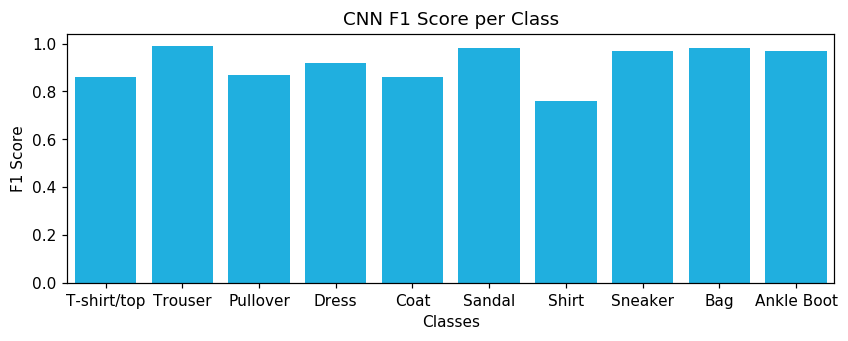

In [74]:
# predicted list
y_pred = []

# freeze gradients
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # make prediction on batch
        output = cnn(images)
        _, predicted = torch.max(output.data, 1)
        # extract predictions
        for p in predicted:
            y_pred.append(int(p))


# accuracy per class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# freeze gradients
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# save accuracy per class for later
all_accuracies = [100 * class_correct[i] / class_total[i] for i in range(10)]

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
            
print("Accuracy on Test Set = " + str((correct/total)*100) + "%")

# plot a graph of class accuracies
plt.figure(dpi=110,figsize=(9,3))
sns.barplot(x=[classes[i] for i in range(10)],y=[0.86,0.99,0.87,0.92,0.86,0.98,0.76,0.97,0.98,0.97], 
            color="deepskyblue")

plt.title("CNN F1 Score per Class")
plt.xlabel("Classes")
plt.ylabel("F1 Score")
plt.show()

The CNN achieves an accuracy of 91.66% on the test set, which is in line with reported values from literature. From the class breakdown, we can see that the CNN is accurate across many classes - achieving over >0.9 F1 score on 6 out of the 10 classes. The scores obtained here are also in line with what was predicted at the very beginning based on the UMAP embedding. For example, we saw that the Bag and Trouser classes were very well separated and, as such the classifier is able to classify these classes very well (0.98 and 0.99 respectively). However, classes that were significantly overlapped in the UMAP embedding have lower accuracies (Shirt and Coat were heavily overlapped and have lower scores of 0.76 and 0.86 respectively). For model improvement it would likely be best to focus on these classes with lower accuracies - especially the Shirt class.

Of course, with high compute power and more time, I would evalutate the model via k-fold cross validation in order to get an idea of the error in the results. I will now move on to the Capsule Network.
___

## Capsule Network

Capsule networks are a new style of neural network introduced in 2017. Briefly, CNNs are made up of "neurones" which are computational nodes that output a scalar value. Capsule networks replace neurones with "capsules", which instead output a vector. The magnitude of the vector indicates the probability of the prescence of an image feature, while the direction provides information about the feature's orientation.

In short, capsule networks are able to accurately capture the spatial relationships between image features. Using a process called routing by agreement, lower level capsules must agree with higher level capsules about the orientation of an image feature.

By fitting a capsule network to the Fashion MNIST dataset we may see improved results. A PyTorch implementation of capsule networks is open sourced here: https://github.com/danielhavir/capsule-network, which is what I have used.

Since the capsule network model is much more demanding than the CNN model, I will only train for a few epochs (10), using the default parameters.

In [12]:
# import capsule network
from trainer import CapsNetTrainer

# define batch size
batch = 128

# define transform - using original values
compose = transforms.Compose([
    # shift by 2 pixels in either direction with zero padding.
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize( ( 0.1307,), ( 0.3081,) )
])

# define data loaders
loaders = {}
trainset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=compose)
loaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=2)

testset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=compose)
loaders['test'] = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=2)

# train capsule network, using original parameters
caps_net = CapsNetTrainer(loaders, batch, 0.001, 3, 0.96, device="cpu", multi_gpu=False)
caps_net.run(10, classes=classes)

######## PYTORCH MODEL BUILT ########
Num params: 8215568
######## RUN STARTED ########
Training...


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1, Batch 1, Loss 165.40716552734375 Accuracy 0.1171875 Time 5.318s
Epoch 1, Batch 2, Loss 150.7431640625 Accuracy 0.15234375 Time 4.785s
Epoch 1, Batch 3, Loss 151.62443033854166 Accuracy 0.12760416666666666 Time 4.806s
Epoch 1, Batch 4, Loss 154.86106872558594 Accuracy 0.140625 Time 4.907s
Epoch 1, Batch 5, Loss 150.22657775878906 Accuracy 0.1296875 Time 5.122s
Epoch 1, Batch 6, Loss 146.29449208577475 Accuracy 0.16015625 Time 5.064s
Epoch 1, Batch 7, Loss 143.39957427978516 Accuracy 0.18415178571428573 Time 4.771s
Epoch 1, Batch 8, Loss 140.52007007598877 Accuracy 0.20703125 Time 4.846s
Epoch 1, Batch 9, Loss 137.83853064643012 Accuracy 0.2248263888888889 Time 4.807s
Epoch 1, Batch 10, Loss 135.3488655090332 Accuracy 0.24609375 Time 4.837s
Epoch 1, Batch 11, Loss 132.9173812866211 Accuracy 0.2528409090909091 Time 4.955s
Epoch 1, Batch 12, Loss 130.48088010152182 Accuracy 0.267578125 Time 4.859s
Epoch 1, Batch 13, Loss 128.08775505652795 Accuracy 0.28365384615384615 Time 4.779s


Epoch 1, Batch 103, Loss 82.42422122399783 Accuracy 0.6325849514563107 Time 5.256s
Epoch 1, Batch 104, Loss 82.2695509837224 Accuracy 0.6335637019230769 Time 5.199s
Epoch 1, Batch 105, Loss 82.10120602562314 Accuracy 0.6348214285714285 Time 5.165s
Epoch 1, Batch 106, Loss 81.96758716511276 Accuracy 0.6353920990566038 Time 5.105s
Epoch 1, Batch 107, Loss 81.78266272143783 Accuracy 0.6366822429906542 Time 5.258s
Epoch 1, Batch 108, Loss 81.65260463290744 Accuracy 0.6371527777777778 Time 5.076s
Epoch 1, Batch 109, Loss 81.47511319501685 Accuracy 0.6389048165137615 Time 5.15s
Epoch 1, Batch 110, Loss 81.33771119551226 Accuracy 0.6401988636363637 Time 5.168s
Epoch 1, Batch 111, Loss 81.17021412892385 Accuracy 0.6409769144144144 Time 5.102s
Epoch 1, Batch 112, Loss 81.0178576878139 Accuracy 0.6425083705357143 Time 5.113s
Epoch 1, Batch 113, Loss 80.82290433360411 Accuracy 0.6440818584070797 Time 5.082s
Epoch 1, Batch 114, Loss 80.67679482175593 Accuracy 0.6456277412280702 Time 5.095s
Epoch 1

Epoch 1, Batch 203, Loss 72.24169698254815 Accuracy 0.7065886699507389 Time 5.172s
Epoch 1, Batch 204, Loss 72.18695547066483 Accuracy 0.70703125 Time 5.119s
Epoch 1, Batch 205, Loss 72.15254684076076 Accuracy 0.7071265243902439 Time 5.112s
Epoch 1, Batch 206, Loss 72.06802642229691 Accuracy 0.7076759708737864 Time 5.106s
Epoch 1, Batch 207, Loss 72.02259157705998 Accuracy 0.7081068840579711 Time 5.118s
Epoch 1, Batch 208, Loss 71.95368908001826 Accuracy 0.7085336538461539 Time 5.126s
Epoch 1, Batch 209, Loss 71.90917308022532 Accuracy 0.7089937200956937 Time 5.133s
Epoch 1, Batch 210, Loss 71.82234853108724 Accuracy 0.7096354166666666 Time 5.103s
Epoch 1, Batch 211, Loss 71.77545659575982 Accuracy 0.7097156398104265 Time 5.137s
Epoch 1, Batch 212, Loss 71.71880587091985 Accuracy 0.7099793632075472 Time 5.212s
Epoch 1, Batch 213, Loss 71.67183328906135 Accuracy 0.7102772887323944 Time 5.075s
Epoch 1, Batch 214, Loss 71.64276745163392 Accuracy 0.7106819509345794 Time 5.097s
Epoch 1, Bat

Epoch 1, Batch 303, Loss 67.48485786765322 Accuracy 0.7417233910891089 Time 5.194s
Epoch 1, Batch 304, Loss 67.45301802534806 Accuracy 0.7419048108552632 Time 5.136s
Epoch 1, Batch 305, Loss 67.42352063538598 Accuracy 0.7420081967213115 Time 5.204s
Epoch 1, Batch 306, Loss 67.38790473439335 Accuracy 0.7422896241830066 Time 5.22s
Epoch 1, Batch 307, Loss 67.35422420191065 Accuracy 0.7425437703583062 Time 5.116s
Epoch 1, Batch 308, Loss 67.31068882384858 Accuracy 0.7428977272727273 Time 5.187s
Epoch 1, Batch 309, Loss 67.2788560120419 Accuracy 0.7429712783171522 Time 5.137s
Epoch 1, Batch 310, Loss 67.2453155148414 Accuracy 0.7433215725806451 Time 5.115s
Epoch 1, Batch 311, Loss 67.21359955766194 Accuracy 0.7435691318327974 Time 5.148s
Epoch 1, Batch 312, Loss 67.18145134510138 Accuracy 0.7438401442307693 Time 5.171s
Epoch 1, Batch 313, Loss 67.13997219926632 Accuracy 0.7441593450479234 Time 5.178s
Epoch 1, Batch 314, Loss 67.10217330106505 Accuracy 0.7444516321656051 Time 5.156s
Epoch 1

Epoch 1, Batch 403, Loss 64.51572503404641 Accuracy 0.7640547456575683 Time 5.153s
Epoch 1, Batch 404, Loss 64.48668444038617 Accuracy 0.7642133353960396 Time 5.105s
Epoch 1, Batch 405, Loss 64.45840414541739 Accuracy 0.7644290123456791 Time 5.127s
Epoch 1, Batch 406, Loss 64.43293752811225 Accuracy 0.7645474137931034 Time 5.101s
Epoch 1, Batch 407, Loss 64.40523328476515 Accuracy 0.7647996007371007 Time 5.121s
Epoch 1, Batch 408, Loss 64.37960703232709 Accuracy 0.7648782169117647 Time 5.192s
Epoch 1, Batch 409, Loss 64.36181228376543 Accuracy 0.7649564486552567 Time 5.084s
Epoch 1, Batch 410, Loss 64.35100294904011 Accuracy 0.7650342987804878 Time 5.13s
Epoch 1, Batch 411, Loss 64.31666549162853 Accuracy 0.7653208637469586 Time 5.108s
Epoch 1, Batch 412, Loss 64.29295220421356 Accuracy 0.7654733009708737 Time 5.324s
Epoch 1, Batch 413, Loss 64.26014682686646 Accuracy 0.7657574152542372 Time 5.173s
Epoch 1, Batch 414, Loss 64.23768226881533 Accuracy 0.7659835446859904 Time 5.208s
Epoch

Epoch 2, Batch 33, Loss 52.75234164613666 Accuracy 0.8503787878787878 Time 5.172s
Epoch 2, Batch 34, Loss 52.74917984008789 Accuracy 0.8506433823529411 Time 5.176s
Epoch 2, Batch 35, Loss 52.6924070085798 Accuracy 0.8495535714285715 Time 5.102s
Epoch 2, Batch 36, Loss 52.553247663709854 Accuracy 0.849609375 Time 5.136s
Epoch 2, Batch 37, Loss 52.49975957097234 Accuracy 0.8511402027027027 Time 5.122s
Epoch 2, Batch 38, Loss 52.47339549817537 Accuracy 0.8517680921052632 Time 5.153s
Epoch 2, Batch 39, Loss 52.361212901580025 Accuracy 0.8521634615384616 Time 5.23s
Epoch 2, Batch 40, Loss 52.43663206100464 Accuracy 0.851953125 Time 5.112s
Epoch 2, Batch 41, Loss 52.48181617550733 Accuracy 0.8508003048780488 Time 5.127s
Epoch 2, Batch 42, Loss 52.451118378412154 Accuracy 0.8511904761904762 Time 5.173s
Epoch 2, Batch 43, Loss 52.398704440094704 Accuracy 0.8519258720930233 Time 5.179s
Epoch 2, Batch 44, Loss 52.46271948380904 Accuracy 0.8512073863636364 Time 5.254s
Epoch 2, Batch 45, Loss 52.3

Epoch 2, Batch 134, Loss 51.41901070324343 Accuracy 0.8548857276119403 Time 5.089s
Epoch 2, Batch 135, Loss 51.443233998616535 Accuracy 0.8546296296296296 Time 5.145s
Epoch 2, Batch 136, Loss 51.41111758176018 Accuracy 0.8548943014705882 Time 5.163s
Epoch 2, Batch 137, Loss 51.40900384944721 Accuracy 0.8550980839416058 Time 5.164s
Epoch 2, Batch 138, Loss 51.40635202933049 Accuracy 0.8550158514492754 Time 5.184s
Epoch 2, Batch 139, Loss 51.38568082301737 Accuracy 0.8550472122302158 Time 5.109s
Epoch 2, Batch 140, Loss 51.38385707310268 Accuracy 0.8554129464285715 Time 5.259s
Epoch 2, Batch 141, Loss 51.37738694535925 Accuracy 0.855219414893617 Time 5.161s
Epoch 2, Batch 142, Loss 51.33904892290142 Accuracy 0.8553036971830986 Time 5.11s
Epoch 2, Batch 143, Loss 51.316922781350726 Accuracy 0.8554414335664335 Time 5.068s
Epoch 2, Batch 144, Loss 51.28103746308221 Accuracy 0.8557942708333334 Time 5.087s
Epoch 2, Batch 145, Loss 51.25905090858196 Accuracy 0.8558728448275862 Time 5.108s
Epoc

Epoch 2, Batch 233, Loss 50.83200898395587 Accuracy 0.85568669527897 Time 5.173s
Epoch 2, Batch 234, Loss 50.83332638862805 Accuracy 0.8558026175213675 Time 5.332s
Epoch 2, Batch 235, Loss 50.82260800625416 Accuracy 0.8559507978723404 Time 5.201s
Epoch 2, Batch 236, Loss 50.81674889386711 Accuracy 0.8557666843220338 Time 5.227s
Epoch 2, Batch 237, Loss 50.806078592936196 Accuracy 0.8557489451476793 Time 5.222s
Epoch 2, Batch 238, Loss 50.80849129813058 Accuracy 0.8557641806722689 Time 5.256s
Epoch 2, Batch 239, Loss 50.783849580517376 Accuracy 0.855942730125523 Time 5.178s
Epoch 2, Batch 240, Loss 50.77858330408732 Accuracy 0.8558919270833333 Time 5.249s
Epoch 2, Batch 241, Loss 50.77268158845387 Accuracy 0.8558739626556017 Time 5.569s
Epoch 2, Batch 242, Loss 50.76408868584751 Accuracy 0.8559529958677686 Time 5.693s
Epoch 2, Batch 243, Loss 50.75831183288323 Accuracy 0.8559349279835391 Time 5.397s
Epoch 2, Batch 244, Loss 50.75014963306364 Accuracy 0.8559490266393442 Time 4.903s
Epoch

Epoch 2, Batch 333, Loss 50.37857739560239 Accuracy 0.8564423798798799 Time 4.553s
Epoch 2, Batch 334, Loss 50.37190299119778 Accuracy 0.8564511601796407 Time 4.506s
Epoch 2, Batch 335, Loss 50.36245818636311 Accuracy 0.8565065298507463 Time 4.571s
Epoch 2, Batch 336, Loss 50.36197908719381 Accuracy 0.8564918154761905 Time 4.483s
Epoch 2, Batch 337, Loss 50.35621177831814 Accuracy 0.8565467359050445 Time 4.717s
Epoch 2, Batch 338, Loss 50.34396477422771 Accuracy 0.8566706730769231 Time 4.571s
Epoch 2, Batch 339, Loss 50.344437500720176 Accuracy 0.8566095132743363 Time 4.529s
Epoch 2, Batch 340, Loss 50.34255182602826 Accuracy 0.856640625 Time 4.507s
Epoch 2, Batch 341, Loss 50.35268093344054 Accuracy 0.8566944648093842 Time 4.574s
Epoch 2, Batch 342, Loss 50.35171003508986 Accuracy 0.8566566154970761 Time 4.574s
Epoch 2, Batch 343, Loss 50.34304107799474 Accuracy 0.8566873177842566 Time 4.511s
Epoch 2, Batch 344, Loss 50.34535627586897 Accuracy 0.8566497093023255 Time 4.531s
Epoch 2, B

Epoch 2, Batch 432, Loss 49.84703720940484 Accuracy 0.8576208043981481 Time 4.946s
Epoch 2, Batch 433, Loss 49.83854819775729 Accuracy 0.8576609411085451 Time 4.946s
Epoch 2, Batch 434, Loss 49.83459178203811 Accuracy 0.8577368951612904 Time 4.958s
Epoch 2, Batch 435, Loss 49.830147438487785 Accuracy 0.857830459770115 Time 5.043s
Epoch 2, Batch 436, Loss 49.8276257296221 Accuracy 0.8577623279816514 Time 5.016s
Epoch 2, Batch 437, Loss 49.82131068493736 Accuracy 0.857837528604119 Time 5.032s
Epoch 2, Batch 438, Loss 49.81520732897057 Accuracy 0.8578053652968036 Time 4.982s
Epoch 2, Batch 439, Loss 49.80680028615617 Accuracy 0.8578623291571754 Time 4.949s
Epoch 2, Batch 440, Loss 49.7900560985912 Accuracy 0.8579723011363637 Time 4.939s
Epoch 2, Batch 441, Loss 49.79312544669153 Accuracy 0.8579577664399093 Time 4.93s
Epoch 2, Batch 442, Loss 49.776711856617645 Accuracy 0.8581023755656109 Time 4.925s
Epoch 2, Batch 443, Loss 49.7747786545592 Accuracy 0.8580699774266366 Time 4.974s
Epoch 2,

Epoch 3, Batch 63, Loss 47.2635988507952 Accuracy 0.8668154761904762 Time 4.934s
Epoch 3, Batch 64, Loss 47.28151386976242 Accuracy 0.8668212890625 Time 4.955s
Epoch 3, Batch 65, Loss 47.275872333233174 Accuracy 0.8663461538461539 Time 4.992s
Epoch 3, Batch 66, Loss 47.24584943597967 Accuracy 0.8662405303030303 Time 4.922s
Epoch 3, Batch 67, Loss 47.212466624245714 Accuracy 0.8663712686567164 Time 4.968s
Epoch 3, Batch 68, Loss 47.1590482487398 Accuracy 0.8663832720588235 Time 4.935s
Epoch 3, Batch 69, Loss 47.10943233102992 Accuracy 0.8660552536231884 Time 4.977s
Epoch 3, Batch 70, Loss 47.10904786246164 Accuracy 0.8655133928571429 Time 4.934s
Epoch 3, Batch 71, Loss 47.12085659403196 Accuracy 0.8656470070422535 Time 4.976s
Epoch 3, Batch 72, Loss 47.10729440053304 Accuracy 0.8655598958333334 Time 4.935s
Epoch 3, Batch 73, Loss 47.116395558396434 Accuracy 0.8659032534246576 Time 4.991s
Epoch 3, Batch 74, Loss 47.0999836792817 Accuracy 0.8656038851351351 Time 5.029s
Epoch 3, Batch 75, 

Epoch 3, Batch 163, Loss 46.5586812540066 Accuracy 0.8709739263803681 Time 4.931s
Epoch 3, Batch 164, Loss 46.55382400605737 Accuracy 0.8711890243902439 Time 4.886s
Epoch 3, Batch 165, Loss 46.54666096080433 Accuracy 0.8712594696969697 Time 4.486s
Epoch 3, Batch 166, Loss 46.54866958526244 Accuracy 0.8711408132530121 Time 4.443s
Epoch 3, Batch 167, Loss 46.54661553205844 Accuracy 0.8710235778443114 Time 4.425s
Epoch 3, Batch 168, Loss 46.526852040063766 Accuracy 0.8711402529761905 Time 4.557s
Epoch 3, Batch 169, Loss 46.50438985881016 Accuracy 0.8713942307692307 Time 4.422s
Epoch 3, Batch 170, Loss 46.47379700155819 Accuracy 0.8717830882352942 Time 4.61s
Epoch 3, Batch 171, Loss 46.472673516524466 Accuracy 0.8716648391812866 Time 4.44s
Epoch 3, Batch 172, Loss 46.478568542835326 Accuracy 0.8713662790697675 Time 4.429s
Epoch 3, Batch 173, Loss 46.49187542248323 Accuracy 0.8711614884393064 Time 4.362s
Epoch 3, Batch 174, Loss 46.48765311844048 Accuracy 0.8712284482758621 Time 4.478s
Epoc

Epoch 3, Batch 262, Loss 46.434057774434564 Accuracy 0.8703184637404581 Time 4.981s
Epoch 3, Batch 263, Loss 46.438266551086656 Accuracy 0.8704253802281369 Time 4.892s
Epoch 3, Batch 264, Loss 46.4502874287692 Accuracy 0.870413115530303 Time 5.034s
Epoch 3, Batch 265, Loss 46.457284229206586 Accuracy 0.8704009433962264 Time 4.947s
Epoch 3, Batch 266, Loss 46.45932141641029 Accuracy 0.8705357142857143 Time 4.906s
Epoch 3, Batch 267, Loss 46.451967832300994 Accuracy 0.8706694756554307 Time 4.915s
Epoch 3, Batch 268, Loss 46.46471403605902 Accuracy 0.8706564832089553 Time 4.935s
Epoch 3, Batch 269, Loss 46.45637757538863 Accuracy 0.8706145446096655 Time 4.962s
Epoch 3, Batch 270, Loss 46.47245871932418 Accuracy 0.8703125 Time 5.001s
Epoch 3, Batch 271, Loss 46.46295336339747 Accuracy 0.8704162822878229 Time 4.9s
Epoch 3, Batch 272, Loss 46.4722384705263 Accuracy 0.8703182444852942 Time 5.057s
Epoch 3, Batch 273, Loss 46.46322866586539 Accuracy 0.8703926282051282 Time 4.938s
Epoch 3, Batch

Epoch 3, Batch 361, Loss 46.249958682918816 Accuracy 0.8714075484764543 Time 4.411s
Epoch 3, Batch 362, Loss 46.23824944680567 Accuracy 0.8715037983425414 Time 4.622s
Epoch 3, Batch 363, Loss 46.24079735285651 Accuracy 0.8714703856749312 Time 4.526s
Epoch 3, Batch 364, Loss 46.2452780859811 Accuracy 0.8714371565934066 Time 4.479s
Epoch 3, Batch 365, Loss 46.234761130973084 Accuracy 0.8714897260273973 Time 4.92s
Epoch 3, Batch 366, Loss 46.23888352399315 Accuracy 0.8714352800546448 Time 4.8s
Epoch 3, Batch 367, Loss 46.2334406174496 Accuracy 0.871508855585831 Time 4.908s
Epoch 3, Batch 368, Loss 46.22937667888144 Accuracy 0.87158203125 Time 4.876s
Epoch 3, Batch 369, Loss 46.22307313748492 Accuracy 0.8715701219512195 Time 4.75s
Epoch 3, Batch 370, Loss 46.22127128807274 Accuracy 0.8716216216216216 Time 5.254s
Epoch 3, Batch 371, Loss 46.21675405990724 Accuracy 0.8715675539083558 Time 4.57s
Epoch 3, Batch 372, Loss 46.213204814541726 Accuracy 0.8716187836021505 Time 4.552s
Epoch 3, Batch

Epoch 3, Batch 461, Loss 46.044000546999456 Accuracy 0.872220715835141 Time 5.522s
Epoch 3, Batch 462, Loss 46.039756436368606 Accuracy 0.8721590909090909 Time 5.514s
Epoch 3, Batch 463, Loss 46.032546807571315 Accuracy 0.8722833423326134 Time 5.511s
Epoch 3, Batch 464, Loss 46.02802974602272 Accuracy 0.8723397090517241 Time 5.565s
Epoch 3, Batch 465, Loss 46.02763214931693 Accuracy 0.8723958333333334 Time 5.494s
Epoch 3, Batch 466, Loss 46.03305272278356 Accuracy 0.8723175965665236 Time 5.459s
Epoch 3, Batch 467, Loss 46.03017468830247 Accuracy 0.8723066113490364 Time 5.512s
Epoch 3, Batch 468, Loss 46.0308262670142 Accuracy 0.8723958333333334 Time 5.49s
Epoch 3, Batch 469, Loss 46.00087002752178 Accuracy 0.87225 Time 4.224s
TRAIN Epoch 3, Loss 46.00087002752178 Accuracy 0.87225 Time 2256.885s
Testing...
TEST Epoch 3, Loss 45.17384597319591 Accuracy 0.8716 Time 145.33s
Training...
Epoch 4, Batch 1, Loss 44.05183410644531 Accuracy 0.875 Time 5.75s
Epoch 4, Batch 2, Loss 43.343557357788

Epoch 4, Batch 93, Loss 44.79595664239699 Accuracy 0.8776041666666666 Time 5.133s
Epoch 4, Batch 94, Loss 44.817088350336604 Accuracy 0.8777426861702128 Time 5.035s
Epoch 4, Batch 95, Loss 44.803535782663445 Accuracy 0.8779605263157895 Time 5.034s
Epoch 4, Batch 96, Loss 44.81199439366659 Accuracy 0.8779296875 Time 5.036s
Epoch 4, Batch 97, Loss 44.83019162207535 Accuracy 0.8778994845360825 Time 5.131s
Epoch 4, Batch 98, Loss 44.83722231339435 Accuracy 0.8777104591836735 Time 5.055s
Epoch 4, Batch 99, Loss 44.77765859738745 Accuracy 0.8782354797979798 Time 5.147s
Epoch 4, Batch 100, Loss 44.78876811981201 Accuracy 0.878203125 Time 5.043s
Epoch 4, Batch 101, Loss 44.79598991469582 Accuracy 0.8784808168316832 Time 5.041s
Epoch 4, Batch 102, Loss 44.76430305780149 Accuracy 0.8783700980392157 Time 5.099s
Epoch 4, Batch 103, Loss 44.766831666520496 Accuracy 0.8787166262135923 Time 5.056s
Epoch 4, Batch 104, Loss 44.7620985691364 Accuracy 0.8789813701923077 Time 5.105s
Epoch 4, Batch 105, Lo

Epoch 4, Batch 193, Loss 44.55118499518676 Accuracy 0.8789264896373057 Time 5.117s
Epoch 4, Batch 194, Loss 44.5519887196649 Accuracy 0.8791478737113402 Time 5.134s
Epoch 4, Batch 195, Loss 44.54773025512695 Accuracy 0.8790865384615385 Time 5.181s
Epoch 4, Batch 196, Loss 44.56501468347044 Accuracy 0.8789859693877551 Time 5.13s
Epoch 4, Batch 197, Loss 44.56035894790882 Accuracy 0.8790053934010152 Time 5.18s
Epoch 4, Batch 198, Loss 44.56554333850591 Accuracy 0.8789457070707071 Time 5.203s
Epoch 4, Batch 199, Loss 44.57468144019045 Accuracy 0.8790829145728644 Time 5.199s
Epoch 4, Batch 200, Loss 44.570127182006836 Accuracy 0.8790234375 Time 5.326s
Epoch 4, Batch 201, Loss 44.5808863094197 Accuracy 0.878847947761194 Time 5.492s
Epoch 4, Batch 202, Loss 44.58506597386729 Accuracy 0.8789836014851485 Time 5.551s
Epoch 4, Batch 203, Loss 44.5702959445897 Accuracy 0.8790794334975369 Time 5.3s
Epoch 4, Batch 204, Loss 44.54898858537861 Accuracy 0.8792509191176471 Time 5.018s
Epoch 4, Batch 20

Epoch 4, Batch 293, Loss 44.487553332852826 Accuracy 0.8810526877133106 Time 5.193s
Epoch 4, Batch 294, Loss 44.50018109431883 Accuracy 0.8809258078231292 Time 5.359s
Epoch 4, Batch 295, Loss 44.48745907282425 Accuracy 0.880958686440678 Time 5.34s
Epoch 4, Batch 296, Loss 44.479230339462696 Accuracy 0.8810441300675675 Time 5.361s
Epoch 4, Batch 297, Loss 44.46926327586576 Accuracy 0.8811026936026936 Time 5.196s
Epoch 4, Batch 298, Loss 44.4652894039282 Accuracy 0.8810559983221476 Time 5.293s
Epoch 4, Batch 299, Loss 44.4715460072393 Accuracy 0.8810357441471572 Time 5.431s
Epoch 4, Batch 300, Loss 44.484364115397135 Accuracy 0.8810677083333334 Time 5.211s
Epoch 4, Batch 301, Loss 44.4865019028369 Accuracy 0.8809956395348837 Time 5.056s
Epoch 4, Batch 302, Loss 44.49994523004191 Accuracy 0.8808981788079471 Time 5.09s
Epoch 4, Batch 303, Loss 44.51662020793449 Accuracy 0.8807755775577558 Time 5.006s
Epoch 4, Batch 304, Loss 44.515506882416574 Accuracy 0.8809107730263158 Time 5.045s
Epoch 

Epoch 4, Batch 392, Loss 44.45931558219754 Accuracy 0.8811981823979592 Time 5.189s
Epoch 4, Batch 393, Loss 44.46457830336865 Accuracy 0.8811227735368957 Time 5.122s
Epoch 4, Batch 394, Loss 44.46063005863712 Accuracy 0.8810279187817259 Time 5.152s
Epoch 4, Batch 395, Loss 44.461088658586334 Accuracy 0.8810126582278481 Time 5.167s
Epoch 4, Batch 396, Loss 44.467666703041154 Accuracy 0.8809382891414141 Time 5.188s
Epoch 4, Batch 397, Loss 44.472000794686956 Accuracy 0.8808249370277078 Time 5.146s
Epoch 4, Batch 398, Loss 44.467248561993316 Accuracy 0.8808103015075377 Time 5.123s
Epoch 4, Batch 399, Loss 44.46817059624464 Accuracy 0.8808936403508771 Time 5.125s
Epoch 4, Batch 400, Loss 44.46637300491333 Accuracy 0.88091796875 Time 5.174s
Epoch 4, Batch 401, Loss 44.45213069582818 Accuracy 0.8810006234413965 Time 5.16s
Epoch 4, Batch 402, Loss 44.4470180397603 Accuracy 0.8811217350746269 Time 5.174s
Epoch 4, Batch 403, Loss 44.45257843812701 Accuracy 0.8811065446650124 Time 5.102s
Epoch 4

Epoch 5, Batch 22, Loss 44.369250384244054 Accuracy 0.8863636363636364 Time 5.315s
Epoch 5, Batch 23, Loss 44.44076521500297 Accuracy 0.8855298913043478 Time 5.225s
Epoch 5, Batch 24, Loss 44.50421476364136 Accuracy 0.88671875 Time 5.123s
Epoch 5, Batch 25, Loss 44.27978302001953 Accuracy 0.8875 Time 5.095s
Epoch 5, Batch 26, Loss 44.37145321185772 Accuracy 0.8852163461538461 Time 5.139s
Epoch 5, Batch 27, Loss 44.337289315682874 Accuracy 0.8862847222222222 Time 5.442s
Epoch 5, Batch 28, Loss 44.3446820122855 Accuracy 0.8858816964285714 Time 5.446s
Epoch 5, Batch 29, Loss 44.31253433227539 Accuracy 0.8855064655172413 Time 5.296s
Epoch 5, Batch 30, Loss 44.28742014567057 Accuracy 0.8856770833333333 Time 5.359s
Epoch 5, Batch 31, Loss 44.20245595132151 Accuracy 0.8855846774193549 Time 5.334s
Epoch 5, Batch 32, Loss 44.14824092388153 Accuracy 0.886474609375 Time 5.203s
Epoch 5, Batch 33, Loss 44.09734379161488 Accuracy 0.8873106060606061 Time 5.431s
Epoch 5, Batch 34, Loss 44.005545784445

Epoch 5, Batch 123, Loss 43.358690339375315 Accuracy 0.892212906504065 Time 5.294s
Epoch 5, Batch 124, Loss 43.36736371440272 Accuracy 0.8922001008064516 Time 5.254s
Epoch 5, Batch 125, Loss 43.35203778076172 Accuracy 0.892 Time 5.281s
Epoch 5, Batch 126, Loss 43.35380475483243 Accuracy 0.8919890873015873 Time 5.285s
Epoch 5, Batch 127, Loss 43.33633774284303 Accuracy 0.8921628937007874 Time 5.283s
Epoch 5, Batch 128, Loss 43.29686310887337 Accuracy 0.892333984375 Time 5.295s
Epoch 5, Batch 129, Loss 43.30893118806588 Accuracy 0.8923207364341085 Time 5.296s
Epoch 5, Batch 130, Loss 43.34107448871319 Accuracy 0.8920072115384615 Time 5.271s
Epoch 5, Batch 131, Loss 43.31510826285559 Accuracy 0.8921159351145038 Time 5.313s
Epoch 5, Batch 132, Loss 43.315923459602125 Accuracy 0.8919862689393939 Time 5.271s
Epoch 5, Batch 133, Loss 43.33515557310635 Accuracy 0.8916823308270677 Time 5.255s
Epoch 5, Batch 134, Loss 43.345043694795066 Accuracy 0.8914995335820896 Time 5.278s
Epoch 5, Batch 135,

Epoch 5, Batch 223, Loss 43.479004949732214 Accuracy 0.8877872757847534 Time 5.469s
Epoch 5, Batch 224, Loss 43.48038561003549 Accuracy 0.8876953125 Time 5.674s
Epoch 5, Batch 225, Loss 43.49266930474175 Accuracy 0.8876736111111111 Time 5.298s
Epoch 5, Batch 226, Loss 43.50111384096399 Accuracy 0.8875138274336283 Time 5.279s
Epoch 5, Batch 227, Loss 43.50259031388203 Accuracy 0.887699614537445 Time 5.334s
Epoch 5, Batch 228, Loss 43.50338467380457 Accuracy 0.8877124451754386 Time 5.318s
Epoch 5, Batch 229, Loss 43.49908702134045 Accuracy 0.8876910480349345 Time 5.513s
Epoch 5, Batch 230, Loss 43.49206819948943 Accuracy 0.8878396739130435 Time 5.694s
Epoch 5, Batch 231, Loss 43.490185114212366 Accuracy 0.8878179112554112 Time 5.521s
Epoch 5, Batch 232, Loss 43.49166437675213 Accuracy 0.8877289870689655 Time 5.708s
Epoch 5, Batch 233, Loss 43.48426365340728 Accuracy 0.8877749463519313 Time 5.589s
Epoch 5, Batch 234, Loss 43.473173597938995 Accuracy 0.8879206730769231 Time 5.414s
Epoch 5,

Epoch 5, Batch 323, Loss 43.422180305693544 Accuracy 0.8876983359133127 Time 5.416s
Epoch 5, Batch 324, Loss 43.41856525562428 Accuracy 0.8877797067901234 Time 5.417s
Epoch 5, Batch 325, Loss 43.42548297588642 Accuracy 0.8876923076923077 Time 5.305s
Epoch 5, Batch 326, Loss 43.41907548026805 Accuracy 0.8876773389570553 Time 5.341s
Epoch 5, Batch 327, Loss 43.42735133039842 Accuracy 0.8876624617737003 Time 5.387s
Epoch 5, Batch 328, Loss 43.42445123486402 Accuracy 0.887719131097561 Time 5.414s
Epoch 5, Batch 329, Loss 43.43267023382216 Accuracy 0.887704217325228 Time 5.443s
Epoch 5, Batch 330, Loss 43.42952603426846 Accuracy 0.8877367424242424 Time 5.437s
Epoch 5, Batch 331, Loss 43.41921381647853 Accuracy 0.8877454682779456 Time 5.388s
Epoch 5, Batch 332, Loss 43.431821156697104 Accuracy 0.887730609939759 Time 5.338s
Epoch 5, Batch 333, Loss 43.41646158945811 Accuracy 0.8878566066066066 Time 5.294s
Epoch 5, Batch 334, Loss 43.4134016893581 Accuracy 0.8879350673652695 Time 5.371s
Epoch 

Epoch 5, Batch 423, Loss 43.29866154086787 Accuracy 0.8888704196217494 Time 4.493s
Epoch 5, Batch 424, Loss 43.29575882317885 Accuracy 0.8889114091981132 Time 4.578s
Epoch 5, Batch 425, Loss 43.291127804026885 Accuracy 0.8889154411764706 Time 4.556s
Epoch 5, Batch 426, Loss 43.29483535480052 Accuracy 0.8888644366197183 Time 4.479s
Epoch 5, Batch 427, Loss 43.29524875078045 Accuracy 0.8889234484777517 Time 4.507s
Epoch 5, Batch 428, Loss 43.29225533922142 Accuracy 0.8889274240654206 Time 4.699s
Epoch 5, Batch 429, Loss 43.28884011826593 Accuracy 0.888967803030303 Time 4.6s
Epoch 5, Batch 430, Loss 43.28476753234863 Accuracy 0.8890261627906977 Time 4.534s
Epoch 5, Batch 431, Loss 43.29407726031168 Accuracy 0.8890479988399071 Time 4.507s
Epoch 5, Batch 432, Loss 43.30181441483674 Accuracy 0.8890154803240741 Time 4.578s
Epoch 5, Batch 433, Loss 43.295945834893274 Accuracy 0.8890011547344111 Time 4.529s
Epoch 5, Batch 434, Loss 43.29844735844344 Accuracy 0.8889868951612904 Time 4.531s
Epoch

Epoch 6, Batch 53, Loss 42.580989909621906 Accuracy 0.8959316037735849 Time 4.603s
Epoch 6, Batch 54, Loss 42.6002451578776 Accuracy 0.8956886574074074 Time 4.548s
Epoch 6, Batch 55, Loss 42.577545166015625 Accuracy 0.8955965909090909 Time 4.585s
Epoch 6, Batch 56, Loss 42.58115421022688 Accuracy 0.8952287946428571 Time 4.654s
Epoch 6, Batch 57, Loss 42.58613619888038 Accuracy 0.8952850877192983 Time 4.643s
Epoch 6, Batch 58, Loss 42.68381967215702 Accuracy 0.8943965517241379 Time 4.89s
Epoch 6, Batch 59, Loss 42.63901694346283 Accuracy 0.8945974576271186 Time 5.154s
Epoch 6, Batch 60, Loss 42.657495180765785 Accuracy 0.89453125 Time 5.29s
Epoch 6, Batch 61, Loss 42.652753048255796 Accuracy 0.8943391393442623 Time 5.403s
Epoch 6, Batch 62, Loss 42.602661748086255 Accuracy 0.8947832661290323 Time 5.35s
Epoch 6, Batch 63, Loss 42.547205425444105 Accuracy 0.8948412698412699 Time 5.457s
Epoch 6, Batch 64, Loss 42.5821812748909 Accuracy 0.89501953125 Time 5.222s
Epoch 6, Batch 65, Loss 42.5

Epoch 6, Batch 154, Loss 42.57205633683638 Accuracy 0.8965604707792207 Time 4.577s
Epoch 6, Batch 155, Loss 42.58957266038464 Accuracy 0.8965725806451613 Time 4.447s
Epoch 6, Batch 156, Loss 42.596992248143906 Accuracy 0.8965344551282052 Time 4.459s
Epoch 6, Batch 157, Loss 42.63163453606283 Accuracy 0.8963475318471338 Time 4.496s
Epoch 6, Batch 158, Loss 42.625607406036764 Accuracy 0.896212420886076 Time 4.445s
Epoch 6, Batch 159, Loss 42.617253237550365 Accuracy 0.8963246855345912 Time 4.44s
Epoch 6, Batch 160, Loss 42.61192507743836 Accuracy 0.896240234375 Time 4.439s
Epoch 6, Batch 161, Loss 42.61275539042787 Accuracy 0.8962053571428571 Time 4.402s
Epoch 6, Batch 162, Loss 42.626000863534436 Accuracy 0.8964120370370371 Time 4.534s
Epoch 6, Batch 163, Loss 42.64411926269531 Accuracy 0.896232745398773 Time 4.448s
Epoch 6, Batch 164, Loss 42.66736286442454 Accuracy 0.8962461890243902 Time 5.118s
Epoch 6, Batch 165, Loss 42.648278970429395 Accuracy 0.8962594696969697 Time 5.116s
Epoch 

Epoch 6, Batch 254, Loss 42.65321692519301 Accuracy 0.8948388287401575 Time 5.14s
Epoch 6, Batch 255, Loss 42.64808274811389 Accuracy 0.8949142156862745 Time 5.104s
Epoch 6, Batch 256, Loss 42.63161584734917 Accuracy 0.894989013671875 Time 5.096s
Epoch 6, Batch 257, Loss 42.62569813412915 Accuracy 0.8949416342412452 Time 5.094s
Epoch 6, Batch 258, Loss 42.63277985328852 Accuracy 0.8947129360465116 Time 5.113s
Epoch 6, Batch 259, Loss 42.639668409428545 Accuracy 0.8946368243243243 Time 5.39s
Epoch 6, Batch 260, Loss 42.63574196742131 Accuracy 0.8947115384615385 Time 5.237s
Epoch 6, Batch 261, Loss 42.64168278193565 Accuracy 0.8946360153256705 Time 4.804s
Epoch 6, Batch 262, Loss 42.65039934638802 Accuracy 0.8946803435114504 Time 4.769s
Epoch 6, Batch 263, Loss 42.65001170807465 Accuracy 0.8946055133079848 Time 4.561s
Epoch 6, Batch 264, Loss 42.64667223439072 Accuracy 0.8945016571969697 Time 4.518s
Epoch 6, Batch 265, Loss 42.65309780768629 Accuracy 0.8943985849056604 Time 4.511s
Epoch 

Epoch 6, Batch 354, Loss 42.52067484020513 Accuracy 0.895215395480226 Time 4.442s
Epoch 6, Batch 355, Loss 42.527765773719466 Accuracy 0.8952904929577464 Time 4.646s
Epoch 6, Batch 356, Loss 42.53005035271806 Accuracy 0.895409058988764 Time 4.431s
Epoch 6, Batch 357, Loss 42.537336728819945 Accuracy 0.8953300070028011 Time 4.443s
Epoch 6, Batch 358, Loss 42.53120516132376 Accuracy 0.8954259776536313 Time 4.504s
Epoch 6, Batch 359, Loss 42.536706377204744 Accuracy 0.8952820334261838 Time 4.516s
Epoch 6, Batch 360, Loss 42.54588156806098 Accuracy 0.8952256944444444 Time 4.424s
Epoch 6, Batch 361, Loss 42.54997582052553 Accuracy 0.895104743767313 Time 4.388s
Epoch 6, Batch 362, Loss 42.54376000462316 Accuracy 0.8950923687845304 Time 4.406s
Epoch 6, Batch 363, Loss 42.54955740474144 Accuracy 0.8950154958677686 Time 4.437s
Epoch 6, Batch 364, Loss 42.548876301272884 Accuracy 0.8950678228021978 Time 4.524s
Epoch 6, Batch 365, Loss 42.55379079531317 Accuracy 0.8951412671232877 Time 4.522s
Epo

Epoch 6, Batch 453, Loss 42.50154185347736 Accuracy 0.8954194260485652 Time 4.722s
Epoch 6, Batch 454, Loss 42.507572921887366 Accuracy 0.8953400330396476 Time 4.953s
Epoch 6, Batch 455, Loss 42.50900212382222 Accuracy 0.8952953296703297 Time 4.968s
Epoch 6, Batch 456, Loss 42.49811639283833 Accuracy 0.8953364857456141 Time 4.978s
Epoch 6, Batch 457, Loss 42.49588909190906 Accuracy 0.8953261761487965 Time 5.222s
Epoch 6, Batch 458, Loss 42.487450470570394 Accuracy 0.8953329694323144 Time 4.873s
Epoch 6, Batch 459, Loss 42.4915547256636 Accuracy 0.8953227124183006 Time 4.94s
Epoch 6, Batch 460, Loss 42.500616504835044 Accuracy 0.8952785326086956 Time 4.794s
Epoch 6, Batch 461, Loss 42.49213577402905 Accuracy 0.8954040130151844 Time 5.117s
Epoch 6, Batch 462, Loss 42.487465689192604 Accuracy 0.8954274891774892 Time 5.182s
Epoch 6, Batch 463, Loss 42.48620592286211 Accuracy 0.8954171166306696 Time 5.152s
Epoch 6, Batch 464, Loss 42.48839278878837 Accuracy 0.8953731142241379 Time 5.157s
Ep

Epoch 7, Batch 84, Loss 42.2831544421968 Accuracy 0.8989955357142857 Time 5.094s
Epoch 7, Batch 85, Loss 42.338474408318014 Accuracy 0.8980698529411765 Time 5.115s
Epoch 7, Batch 86, Loss 42.281848730042924 Accuracy 0.8985283430232558 Time 5.123s
Epoch 7, Batch 87, Loss 42.28053555543395 Accuracy 0.8982579022988506 Time 4.97s
Epoch 7, Batch 88, Loss 42.27457909150557 Accuracy 0.8985262784090909 Time 4.662s
Epoch 7, Batch 89, Loss 42.24419741684132 Accuracy 0.8987008426966292 Time 4.571s
Epoch 7, Batch 90, Loss 42.22554439968533 Accuracy 0.8986111111111111 Time 4.519s
Epoch 7, Batch 91, Loss 42.25862599467183 Accuracy 0.8984375 Time 4.507s
Epoch 7, Batch 92, Loss 42.2541386977486 Accuracy 0.8980129076086957 Time 4.481s
Epoch 7, Batch 93, Loss 42.22752815164546 Accuracy 0.8983534946236559 Time 4.836s
Epoch 7, Batch 94, Loss 42.25923335298579 Accuracy 0.8983543882978723 Time 5.219s
Epoch 7, Batch 95, Loss 42.26815253809879 Accuracy 0.8984375 Time 5.173s
Epoch 7, Batch 96, Loss 42.23969229

Epoch 7, Batch 184, Loss 41.95595339070196 Accuracy 0.8992017663043478 Time 4.543s
Epoch 7, Batch 185, Loss 41.95726108035526 Accuracy 0.8991131756756757 Time 4.472s
Epoch 7, Batch 186, Loss 41.96072765063214 Accuracy 0.8991095430107527 Time 4.395s
Epoch 7, Batch 187, Loss 41.94827682576715 Accuracy 0.8994819518716578 Time 4.469s
Epoch 7, Batch 188, Loss 41.96704976102139 Accuracy 0.8992686170212766 Time 4.444s
Epoch 7, Batch 189, Loss 41.96637578489919 Accuracy 0.8993055555555556 Time 4.572s
Epoch 7, Batch 190, Loss 41.96659262807746 Accuracy 0.8993421052631579 Time 5.129s
Epoch 7, Batch 191, Loss 41.974652155531636 Accuracy 0.8992146596858639 Time 5.168s
Epoch 7, Batch 192, Loss 41.99341587225596 Accuracy 0.8992106119791666 Time 5.07s
Epoch 7, Batch 193, Loss 41.9730912440799 Accuracy 0.8994899611398963 Time 5.206s
Epoch 7, Batch 194, Loss 41.9728856824108 Accuracy 0.899645618556701 Time 5.141s
Epoch 7, Batch 195, Loss 41.960887067745894 Accuracy 0.8996394230769231 Time 5.096s
Epoch 

Epoch 7, Batch 283, Loss 41.91521808368157 Accuracy 0.8991552561837456 Time 4.445s
Epoch 7, Batch 284, Loss 41.916206883712555 Accuracy 0.8992352552816901 Time 4.459s
Epoch 7, Batch 285, Loss 41.911432861863524 Accuracy 0.8992050438596492 Time 4.451s
Epoch 7, Batch 286, Loss 41.89696369304524 Accuracy 0.8993935751748252 Time 4.49s
Epoch 7, Batch 287, Loss 41.881406976786224 Accuracy 0.899526350174216 Time 4.432s
Epoch 7, Batch 288, Loss 41.88017335202959 Accuracy 0.8994411892361112 Time 4.4s
Epoch 7, Batch 289, Loss 41.88328219615052 Accuracy 0.8994647491349481 Time 4.571s
Epoch 7, Batch 290, Loss 41.888205192829 Accuracy 0.8992995689655172 Time 4.984s
Epoch 7, Batch 291, Loss 41.876450555021414 Accuracy 0.8994039948453608 Time 5.041s
Epoch 7, Batch 292, Loss 41.88715224070092 Accuracy 0.8994274400684932 Time 4.877s
Epoch 7, Batch 293, Loss 41.89408689635606 Accuracy 0.899557380546075 Time 5.321s
Epoch 7, Batch 294, Loss 41.89309585986494 Accuracy 0.8994738520408163 Time 5.019s
Epoch 7

Epoch 7, Batch 382, Loss 41.91206797255271 Accuracy 0.8992760143979057 Time 4.935s
Epoch 7, Batch 383, Loss 41.917271995046434 Accuracy 0.8992126305483029 Time 4.959s
Epoch 7, Batch 384, Loss 41.92328224579493 Accuracy 0.8992106119791666 Time 5.011s
Epoch 7, Batch 385, Loss 41.93732636687044 Accuracy 0.8990868506493507 Time 4.951s
Epoch 7, Batch 386, Loss 41.937962685224306 Accuracy 0.8991054080310881 Time 4.949s
Epoch 7, Batch 387, Loss 41.93399777276879 Accuracy 0.8991440568475452 Time 4.962s
Epoch 7, Batch 388, Loss 41.927321738803506 Accuracy 0.8992630476804123 Time 4.964s
Epoch 7, Batch 389, Loss 41.92137544136734 Accuracy 0.8992609254498715 Time 5.036s
Epoch 7, Batch 390, Loss 41.92370104667468 Accuracy 0.89921875 Time 4.978s
Epoch 7, Batch 391, Loss 41.917811918136714 Accuracy 0.8992966751918159 Time 4.997s
Epoch 7, Batch 392, Loss 41.91950581025104 Accuracy 0.8992745535714286 Time 4.974s
Epoch 7, Batch 393, Loss 41.931981181370396 Accuracy 0.899232665394402 Time 4.996s
Epoch 7,

Epoch 8, Batch 11, Loss 41.361485567959875 Accuracy 0.8991477272727273 Time 4.984s
Epoch 8, Batch 12, Loss 41.17828210194906 Accuracy 0.90234375 Time 5.043s
Epoch 8, Batch 13, Loss 41.40617517324594 Accuracy 0.9020432692307693 Time 4.979s
Epoch 8, Batch 14, Loss 41.47611291067941 Accuracy 0.90234375 Time 5.15s
Epoch 8, Batch 15, Loss 41.699459584554035 Accuracy 0.9010416666666666 Time 5.106s
Epoch 8, Batch 16, Loss 41.62957501411438 Accuracy 0.8994140625 Time 5.29s
Epoch 8, Batch 17, Loss 41.737051122328815 Accuracy 0.8993566176470589 Time 5.319s
Epoch 8, Batch 18, Loss 41.870020124647354 Accuracy 0.8997395833333334 Time 5.067s
Epoch 8, Batch 19, Loss 41.89204366583573 Accuracy 0.8988486842105263 Time 5.033s
Epoch 8, Batch 20, Loss 41.96388664245605 Accuracy 0.89921875 Time 5.268s
Epoch 8, Batch 21, Loss 41.990519205729164 Accuracy 0.8999255952380952 Time 5.064s
Epoch 8, Batch 22, Loss 42.03883916681463 Accuracy 0.8973721590909091 Time 5.114s
Epoch 8, Batch 23, Loss 42.11327080104662 A

Epoch 8, Batch 113, Loss 41.50315475463867 Accuracy 0.8995436946902655 Time 5.003s
Epoch 8, Batch 114, Loss 41.47285819471928 Accuracy 0.8997395833333334 Time 5.084s
Epoch 8, Batch 115, Loss 41.445011901855466 Accuracy 0.899796195652174 Time 5.042s
Epoch 8, Batch 116, Loss 41.44292180291538 Accuracy 0.8999191810344828 Time 5.056s
Epoch 8, Batch 117, Loss 41.436000008868355 Accuracy 0.9000400641025641 Time 5.415s
Epoch 8, Batch 118, Loss 41.41480685088594 Accuracy 0.9000264830508474 Time 5.248s
Epoch 8, Batch 119, Loss 41.45229374861517 Accuracy 0.8996848739495799 Time 4.976s
Epoch 8, Batch 120, Loss 41.44144163131714 Accuracy 0.8999348958333333 Time 4.857s
Epoch 8, Batch 121, Loss 41.40937915518264 Accuracy 0.8999870867768595 Time 4.994s
Epoch 8, Batch 122, Loss 41.40367364101723 Accuracy 0.9002305327868853 Time 5.156s
Epoch 8, Batch 123, Loss 41.43301940545803 Accuracy 0.8998983739837398 Time 5.032s
Epoch 8, Batch 124, Loss 41.43556022644043 Accuracy 0.8998865927419355 Time 5.098s
Epo

Epoch 8, Batch 213, Loss 41.20907270404655 Accuracy 0.9030956572769953 Time 4.442s
Epoch 8, Batch 214, Loss 41.20522907292732 Accuracy 0.9031103971962616 Time 4.371s
Epoch 8, Batch 215, Loss 41.20790541892828 Accuracy 0.903125 Time 4.401s
Epoch 8, Batch 216, Loss 41.21469607176604 Accuracy 0.9032118055555556 Time 4.382s
Epoch 8, Batch 217, Loss 41.21948453138501 Accuracy 0.903153801843318 Time 4.383s
Epoch 8, Batch 218, Loss 41.2082847455226 Accuracy 0.9032396788990825 Time 4.456s
Epoch 8, Batch 219, Loss 41.19330788529627 Accuracy 0.9033247716894978 Time 4.443s
Epoch 8, Batch 220, Loss 41.18399092934349 Accuracy 0.9034801136363636 Time 4.46s
Epoch 8, Batch 221, Loss 41.185599365924816 Accuracy 0.9033512443438914 Time 4.621s
Epoch 8, Batch 222, Loss 41.18668236603608 Accuracy 0.9034698761261262 Time 4.392s
Epoch 8, Batch 223, Loss 41.19115039158295 Accuracy 0.9035173766816144 Time 4.387s
Epoch 8, Batch 224, Loss 41.2082998922893 Accuracy 0.9032854352678571 Time 4.355s
Epoch 8, Batch 22

Epoch 8, Batch 313, Loss 41.3506289838602 Accuracy 0.9026058306709265 Time 4.418s
Epoch 8, Batch 314, Loss 41.351626268617665 Accuracy 0.9025676751592356 Time 4.51s
Epoch 8, Batch 315, Loss 41.3454956902398 Accuracy 0.9025297619047619 Time 4.325s
Epoch 8, Batch 316, Loss 41.34024575390393 Accuracy 0.9025909810126582 Time 4.491s
Epoch 8, Batch 317, Loss 41.34327104490262 Accuracy 0.9026518138801262 Time 4.388s
Epoch 8, Batch 318, Loss 41.35565103974732 Accuracy 0.902589426100629 Time 4.343s
Epoch 8, Batch 319, Loss 41.35073234295023 Accuracy 0.9027478448275862 Time 4.366s
Epoch 8, Batch 320, Loss 41.36334159374237 Accuracy 0.9026611328125 Time 4.358s
Epoch 8, Batch 321, Loss 41.36498424494378 Accuracy 0.9026966510903427 Time 4.353s
Epoch 8, Batch 322, Loss 41.37516583270908 Accuracy 0.9025863742236024 Time 4.417s
Epoch 8, Batch 323, Loss 41.381121585243626 Accuracy 0.9024767801857585 Time 4.347s
Epoch 8, Batch 324, Loss 41.38851039792284 Accuracy 0.902367862654321 Time 4.336s
Epoch 8, B

Epoch 8, Batch 413, Loss 41.405986250168475 Accuracy 0.9022397094430993 Time 4.409s
Epoch 8, Batch 414, Loss 41.4065168445237 Accuracy 0.9022871376811594 Time 4.373s
Epoch 8, Batch 415, Loss 41.41346833562277 Accuracy 0.9023155120481928 Time 4.369s
Epoch 8, Batch 416, Loss 41.417785415282616 Accuracy 0.9022686298076923 Time 4.37s
Epoch 8, Batch 417, Loss 41.415712315401585 Accuracy 0.902296912470024 Time 4.377s
Epoch 8, Batch 418, Loss 41.40722002823387 Accuracy 0.9023624401913876 Time 4.376s
Epoch 8, Batch 419, Loss 41.41081301522995 Accuracy 0.9023717183770883 Time 4.405s
Epoch 8, Batch 420, Loss 41.40734022231329 Accuracy 0.9024367559523809 Time 4.427s
Epoch 8, Batch 421, Loss 41.39597226321839 Accuracy 0.9025571555819477 Time 4.345s
Epoch 8, Batch 422, Loss 41.39811126202768 Accuracy 0.9026214454976303 Time 4.474s
Epoch 8, Batch 423, Loss 41.398866784206234 Accuracy 0.9025746158392435 Time 4.4s
Epoch 8, Batch 424, Loss 41.402043486541174 Accuracy 0.902564858490566 Time 4.41s
Epoch 

Epoch 9, Batch 43, Loss 41.418203220811 Accuracy 0.899890988372093 Time 4.405s
Epoch 9, Batch 44, Loss 41.44933804598722 Accuracy 0.8996803977272727 Time 4.423s
Epoch 9, Batch 45, Loss 41.501854027642146 Accuracy 0.8994791666666667 Time 4.363s
Epoch 9, Batch 46, Loss 41.447365470554516 Accuracy 0.9001358695652174 Time 4.423s
Epoch 9, Batch 47, Loss 41.453991017443066 Accuracy 0.9005984042553191 Time 4.433s
Epoch 9, Batch 48, Loss 41.41372617085775 Accuracy 0.9010416666666666 Time 4.452s
Epoch 9, Batch 49, Loss 41.539506717604034 Accuracy 0.9006696428571429 Time 4.478s
Epoch 9, Batch 50, Loss 41.54805801391601 Accuracy 0.900625 Time 4.422s
Epoch 9, Batch 51, Loss 41.53855230294022 Accuracy 0.9013480392156863 Time 4.412s
Epoch 9, Batch 52, Loss 41.56254863739014 Accuracy 0.9006911057692307 Time 4.545s
Epoch 9, Batch 53, Loss 41.53169862279352 Accuracy 0.9009433962264151 Time 4.468s
Epoch 9, Batch 54, Loss 41.41922343218768 Accuracy 0.9020543981481481 Time 4.427s
Epoch 9, Batch 55, Loss 4

Epoch 9, Batch 143, Loss 40.96960051743301 Accuracy 0.904611013986014 Time 4.434s
Epoch 9, Batch 144, Loss 40.96115631527371 Accuracy 0.9046223958333334 Time 4.438s
Epoch 9, Batch 145, Loss 40.977789043558055 Accuracy 0.9047413793103448 Time 4.439s
Epoch 9, Batch 146, Loss 40.98104288806654 Accuracy 0.9047517123287672 Time 4.586s
Epoch 9, Batch 147, Loss 40.99876870914381 Accuracy 0.9047619047619048 Time 4.381s
Epoch 9, Batch 148, Loss 40.994484411703574 Accuracy 0.9048247466216216 Time 4.401s
Epoch 9, Batch 149, Loss 40.99318935727113 Accuracy 0.904886744966443 Time 4.375s
Epoch 9, Batch 150, Loss 40.988702621459964 Accuracy 0.90484375 Time 4.444s
Epoch 9, Batch 151, Loss 40.98663605443689 Accuracy 0.9050082781456954 Time 4.378s
Epoch 9, Batch 152, Loss 40.9949241688377 Accuracy 0.9046566611842105 Time 4.355s
Epoch 9, Batch 153, Loss 40.990468118705 Accuracy 0.9047691993464052 Time 4.384s
Epoch 9, Batch 154, Loss 41.00759275857504 Accuracy 0.9048295454545454 Time 4.387s
Epoch 9, Batch

Epoch 9, Batch 243, Loss 40.998795999911586 Accuracy 0.9060249485596708 Time 4.429s
Epoch 9, Batch 244, Loss 41.01121789900983 Accuracy 0.9057697233606558 Time 4.336s
Epoch 9, Batch 245, Loss 41.00489405417929 Accuracy 0.9058673469387755 Time 4.493s
Epoch 9, Batch 246, Loss 40.993604473951386 Accuracy 0.9059006605691057 Time 4.378s
Epoch 9, Batch 247, Loss 40.99827711591836 Accuracy 0.9058388157894737 Time 4.341s
Epoch 9, Batch 248, Loss 41.02383055225496 Accuracy 0.9057459677419355 Time 4.409s
Epoch 9, Batch 249, Loss 41.01970819680088 Accuracy 0.9057479919678715 Time 4.346s
Epoch 9, Batch 250, Loss 41.02656463623047 Accuracy 0.9056875 Time 4.374s
Epoch 9, Batch 251, Loss 41.01895266225139 Accuracy 0.9058453685258964 Time 4.373s
Epoch 9, Batch 252, Loss 41.0356827539111 Accuracy 0.9055679563492064 Time 4.401s
Epoch 9, Batch 253, Loss 41.03327109596946 Accuracy 0.9056941699604744 Time 4.423s
Epoch 9, Batch 254, Loss 41.03088637224332 Accuracy 0.9056348425196851 Time 4.43s
Epoch 9, Batc

Epoch 9, Batch 342, Loss 40.93645528603715 Accuracy 0.9067754020467836 Time 4.407s
Epoch 9, Batch 343, Loss 40.93621833956971 Accuracy 0.9067510932944607 Time 4.478s
Epoch 9, Batch 344, Loss 40.943971223609395 Accuracy 0.9067950581395349 Time 4.391s
Epoch 9, Batch 345, Loss 40.93968637438788 Accuracy 0.9067708333333333 Time 4.385s
Epoch 9, Batch 346, Loss 40.93143325320558 Accuracy 0.9068144869942196 Time 4.372s
Epoch 9, Batch 347, Loss 40.93491560306604 Accuracy 0.9067678314121037 Time 4.498s
Epoch 9, Batch 348, Loss 40.940883165118336 Accuracy 0.9066540948275862 Time 4.379s
Epoch 9, Batch 349, Loss 40.95533123945438 Accuracy 0.9065633954154728 Time 4.489s
Epoch 9, Batch 350, Loss 40.951226337977815 Accuracy 0.9064955357142858 Time 4.536s
Epoch 9, Batch 351, Loss 40.95828877419149 Accuracy 0.9064948361823362 Time 4.444s
Epoch 9, Batch 352, Loss 40.96186583692377 Accuracy 0.9063387784090909 Time 4.465s
Epoch 9, Batch 353, Loss 40.96205569259168 Accuracy 0.906316395184136 Time 4.386s
Ep

Epoch 9, Batch 442, Loss 40.87418320599724 Accuracy 0.9060202205882353 Time 4.448s
Epoch 9, Batch 443, Loss 40.87786607763837 Accuracy 0.9060560101580135 Time 4.411s
Epoch 9, Batch 444, Loss 40.87735924420056 Accuracy 0.9061092342342343 Time 4.445s
Epoch 9, Batch 445, Loss 40.88387406595637 Accuracy 0.9060919943820225 Time 4.538s
Epoch 9, Batch 446, Loss 40.884245252395424 Accuracy 0.906109865470852 Time 4.436s
Epoch 9, Batch 447, Loss 40.88079272447283 Accuracy 0.9061626118568232 Time 4.403s
Epoch 9, Batch 448, Loss 40.87915825843811 Accuracy 0.9062151227678571 Time 4.363s
Epoch 9, Batch 449, Loss 40.880448288269726 Accuracy 0.9061804008908686 Time 4.441s
Epoch 9, Batch 450, Loss 40.88752023484972 Accuracy 0.9061284722222223 Time 4.415s
Epoch 9, Batch 451, Loss 40.88377551228931 Accuracy 0.9060940964523282 Time 4.407s
Epoch 9, Batch 452, Loss 40.87451887552717 Accuracy 0.906163578539823 Time 4.58s
Epoch 9, Batch 453, Loss 40.861987789735096 Accuracy 0.9062327538631346 Time 4.401s
Epoc

Epoch 10, Batch 72, Loss 40.30259058210585 Accuracy 0.9067925347222222 Time 4.423s
Epoch 10, Batch 73, Loss 40.289917201212006 Accuracy 0.9074272260273972 Time 4.44s
Epoch 10, Batch 74, Loss 40.31056589693637 Accuracy 0.9074113175675675 Time 4.458s
Epoch 10, Batch 75, Loss 40.29850611368815 Accuracy 0.9071875 Time 4.479s
Epoch 10, Batch 76, Loss 40.32620153929058 Accuracy 0.9071751644736842 Time 4.386s
Epoch 10, Batch 77, Loss 40.30173373531986 Accuracy 0.9076704545454546 Time 4.439s
Epoch 10, Batch 78, Loss 40.27651498256586 Accuracy 0.9082532051282052 Time 4.603s
Epoch 10, Batch 79, Loss 40.2677683287029 Accuracy 0.9084256329113924 Time 4.498s
Epoch 10, Batch 80, Loss 40.251990127563474 Accuracy 0.9083984375 Time 4.433s
Epoch 10, Batch 81, Loss 40.24039190786856 Accuracy 0.9084683641975309 Time 4.361s
Epoch 10, Batch 82, Loss 40.240472886620495 Accuracy 0.9084413109756098 Time 4.433s
Epoch 10, Batch 83, Loss 40.2510201327772 Accuracy 0.908226656626506 Time 4.386s
Epoch 10, Batch 84, 

Epoch 10, Batch 171, Loss 40.18313362166198 Accuracy 0.9093110380116959 Time 4.388s
Epoch 10, Batch 172, Loss 40.19032575917799 Accuracy 0.9094295058139535 Time 4.468s
Epoch 10, Batch 173, Loss 40.192543294388436 Accuracy 0.9095917630057804 Time 4.367s
Epoch 10, Batch 174, Loss 40.18796863775144 Accuracy 0.9094827586206896 Time 4.373s
Epoch 10, Batch 175, Loss 40.16943987165178 Accuracy 0.9095089285714286 Time 4.45s
Epoch 10, Batch 176, Loss 40.15888569571755 Accuracy 0.9095348011363636 Time 4.409s
Epoch 10, Batch 177, Loss 40.18743002077954 Accuracy 0.9093396892655368 Time 4.403s
Epoch 10, Batch 178, Loss 40.17848636327165 Accuracy 0.9092345505617978 Time 4.431s
Epoch 10, Batch 179, Loss 40.16561263100395 Accuracy 0.9094361033519553 Time 4.599s
Epoch 10, Batch 180, Loss 40.15845135582818 Accuracy 0.9094618055555556 Time 4.44s
Epoch 10, Batch 181, Loss 40.15145903529383 Accuracy 0.9095303867403315 Time 4.401s
Epoch 10, Batch 182, Loss 40.17943522694347 Accuracy 0.9095982142857143 Time 

Epoch 10, Batch 269, Loss 40.35166814867892 Accuracy 0.9090381040892194 Time 4.373s
Epoch 10, Batch 270, Loss 40.339680721141676 Accuracy 0.9090856481481482 Time 4.381s
Epoch 10, Batch 271, Loss 40.32624842232004 Accuracy 0.9091328413284133 Time 4.393s
Epoch 10, Batch 272, Loss 40.32057083354277 Accuracy 0.9091509650735294 Time 4.37s
Epoch 10, Batch 273, Loss 40.331847599574495 Accuracy 0.9091975732600732 Time 4.375s
Epoch 10, Batch 274, Loss 40.353963225427336 Accuracy 0.9090157390510949 Time 4.571s
Epoch 10, Batch 275, Loss 40.352529005570844 Accuracy 0.9090340909090909 Time 4.535s
Epoch 10, Batch 276, Loss 40.358971761620566 Accuracy 0.9089673913043478 Time 4.405s
Epoch 10, Batch 277, Loss 40.3556073598483 Accuracy 0.9090421931407943 Time 4.412s
Epoch 10, Batch 278, Loss 40.34200857697631 Accuracy 0.9090883543165468 Time 4.512s
Epoch 10, Batch 279, Loss 40.336322046095326 Accuracy 0.9090781810035843 Time 4.374s
Epoch 10, Batch 280, Loss 40.32547882625035 Accuracy 0.9091238839285715 

Epoch 10, Batch 367, Loss 40.24501962687729 Accuracy 0.9098688692098093 Time 4.435s
Epoch 10, Batch 368, Loss 40.24542895607326 Accuracy 0.9098378057065217 Time 4.498s
Epoch 10, Batch 369, Loss 40.23605277415537 Accuracy 0.9099339430894309 Time 4.571s
Epoch 10, Batch 370, Loss 40.23775615176639 Accuracy 0.909839527027027 Time 4.39s
Epoch 10, Batch 371, Loss 40.227720409712056 Accuracy 0.9099140835579514 Time 4.416s
Epoch 10, Batch 372, Loss 40.22921429910967 Accuracy 0.9099042338709677 Time 4.438s
Epoch 10, Batch 373, Loss 40.241646927738955 Accuracy 0.9099153820375335 Time 4.398s
Epoch 10, Batch 374, Loss 40.25137184265463 Accuracy 0.9098011363636364 Time 4.467s
Epoch 10, Batch 375, Loss 40.26261879475911 Accuracy 0.9096041666666667 Time 4.406s
Epoch 10, Batch 376, Loss 40.25751382746595 Accuracy 0.9097199135638298 Time 4.385s
Epoch 10, Batch 377, Loss 40.2489526581701 Accuracy 0.909793600795756 Time 4.333s
Epoch 10, Batch 378, Loss 40.25378626868839 Accuracy 0.9097842261904762 Time 4

Epoch 10, Batch 465, Loss 40.374500323880106 Accuracy 0.9086021505376344 Time 4.392s
Epoch 10, Batch 466, Loss 40.37711553614539 Accuracy 0.9085803379828327 Time 4.428s
Epoch 10, Batch 467, Loss 40.37803227590034 Accuracy 0.9085753479657388 Time 4.483s
Epoch 10, Batch 468, Loss 40.37978890410855 Accuracy 0.9086037660256411 Time 4.476s
Epoch 10, Batch 469, Loss 40.359256231962746 Accuracy 0.9086333333333333 Time 3.372s
TRAIN Epoch 10, Loss 40.359256231962746 Accuracy 0.9086333333333333 Time 2080.978s
Testing...
TEST Epoch 10, Loss 41.03398844562 Accuracy 0.8976 Time 115.606s
Accuracy of T-shirt/top : 81 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 85 %
Accuracy of Dress : 94 %
Accuracy of  Coat : 78 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 67 %
Accuracy of Sneaker : 97 %
Accuracy of   Bag : 98 %
Accuracy of Ankle Boot : 96 %


The Capsule Network achieved an accuracy of 89.76% on the test set, which is lower than the accuracy achieved by the CNN (91.66%). However, I only trained for 10 epochs, so it could be that longer training would still produce better results.

I will now show the performance of the Capsule Network on each class and compare with the CNN. To reiterate, with more time I would have generated the classification report and used F1 score to compare, instead I am using accuracy.

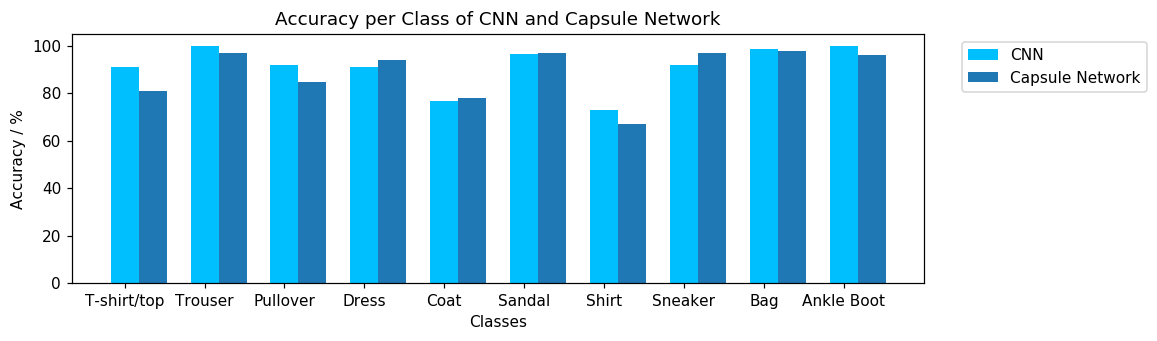

In [75]:
# define values
labels = [classes[i] for i in range(10)]
cnn_acc = all_accuracies
caps_acc = [81,97,85,94,78,97,67,97,98,96]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# create plot
fig, ax = plt.subplots(dpi=110,figsize=(10,3))
rects1 = ax.bar(x, cnn_acc, width, label='CNN', align='center',color='deepskyblue')
rects2 = ax.bar(x+width, caps_acc, width, label='Capsule Network', align='center')

ax.set_xlabel('Classes')
ax.set_ylabel('Accuracy / %')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.27,1),loc='upper right')
plt.title("Accuracy per Class of CNN and Capsule Network")
plt.show()

We can see that the CNN outperforms the Capsule Network in 6 out of 10 classes, in most cases by a significant margin. However, the Capsule Network also outperforms the CNN across several classes. This warrants further investigation - more training may also produce improved performance for other classes.

*Based on comparing accuracy across the test set, the CNN is the better performing model, which is also a far more lightweight solution.*

A key takeaway from this work is that the complex model is not always better and if higher performance can be achieved with a much simpler model, we should take this approach. Even if longer training produces better results, we still have to consider the time/compute limitations - is training for many hours to achieve marginal improvement worth it?
___

## 4. Improvements

We could very likely achieve better performance with the CNN through a hyperparameter (batch size, learning rate etc.) optimisation using a grid search. This is very computationally intense so I have not done this. Furthermore, we may be able to achieve improved performance with a data augmentation technique such as using a Generative Adversarial Network (GAN) to synthesise more Fashion MNIST images for training. Again, this would be very computationally intense, so I have not attempted it. 

In summary, I have trained two different models on the Fashion MNIST dataset and compared their performance via an accuracy metric. I found that the 5 layer CNN marginally outperformed the Capsule Network, achieving an accuracy of 91.66% on the test set. I have concluded by suggesting improvements that could be made to the model through hyperparameter optimisation and data augmentation.

___

Thank you for reading my work and considering me for the team :)